# Module 05: Advanced LWLR Techniques

**Beyond the Basics** | *Production-Ready Skills*

---

## 🎯 What You'll Learn

This notebook assumes you already understand basic LWLR from the Tutorial. Here we go **deeper**:

| Topic | Why It Matters |
|-------|---------------|
| **Different Kernel Functions** | Gaussian isn't always best |
| **Automatic Tau Selection** | Cross-validation for optimal bandwidth |
| **Multi-dimensional LWLR** | Real data has multiple features |
| **Leave-One-Out CV** | Efficient model selection |
| **Comparison with KNN & Kernel Ridge** | When to use what |

**Prerequisites:** Complete `LWLR_Tutorial_Complete.ipynb` first!

## 1. 🔧 Setup & Imports

In [2]:
# ═══════════════════════════════════════════════════════════════
# 🔧 SETUP & IMPORTS
# ═══════════════════════════════════════════════════════════════
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import cross_val_score, KFold
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.datasets import fetch_california_housing
from sklearn.preprocessing import StandardScaler
import warnings
warnings.filterwarnings('ignore')

# Plot styling
plt.rcParams['figure.figsize'] = (12, 5)
plt.rcParams['font.size'] = 10
np.random.seed(42)

print("✅ Setup complete!")
print("📦 Libraries: NumPy, Matplotlib, Scikit-learn")
print("\n🚀 Ready for Advanced LWLR techniques!")

✅ Setup complete!
📦 Libraries: NumPy, Matplotlib, Scikit-learn

🚀 Ready for Advanced LWLR techniques!


## 2. 🎭 Different Kernel Functions

The Gaussian kernel is popular, but it's not the only option. Different kernels have different properties:

| Kernel | Formula | Properties |
|--------|---------|------------|
| **Gaussian** | $\exp(-u^2/2)$ | Smooth, infinite support |
| **Epanechnikov** | $\frac{3}{4}(1-u^2)$ if $|u| \leq 1$ | Optimal MSE efficiency |
| **Tricube** | $(1-|u|^3)^3$ if $|u| \leq 1$ | Very smooth at boundaries |
| **Quartic** | $(1-u^2)^2$ if $|u| \leq 1$ | Good balance |

Where $u = \frac{||x - x_{query}||}{\tau}$ (normalized distance)

**Key insight:** Compact kernels (Epanechnikov, Tricube) have finite support – points beyond $\tau$ get **exactly zero weight**, not just very small weight. This can speed up computation!

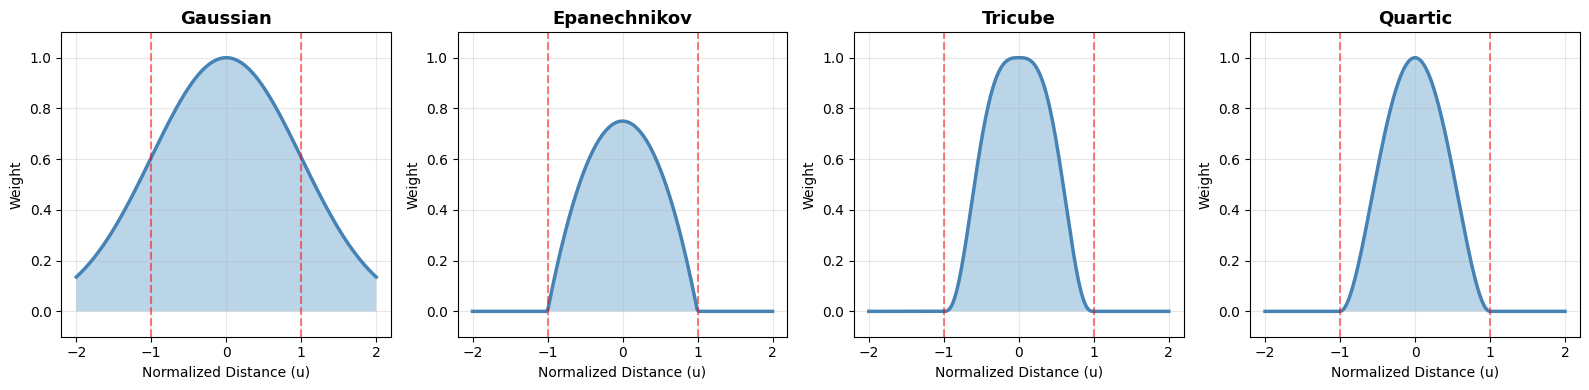

📊 Key Observations:
   • Gaussian: Never reaches zero (infinite support)
   • Others: Drop to exactly 0 at |u| = 1 (compact support)
   • Tricube: Smoothest transition to zero


In [3]:
# ═══════════════════════════════════════════════════════════════
# 🎭 KERNEL FUNCTION IMPLEMENTATIONS
# ═══════════════════════════════════════════════════════════════

def gaussian_kernel(u):
    """Gaussian kernel - infinite support, very smooth"""
    return np.exp(-0.5 * u**2)

def epanechnikov_kernel(u):
    """Epanechnikov kernel - optimal MSE efficiency, compact support"""
    weights = np.where(np.abs(u) <= 1, 0.75 * (1 - u**2), 0)
    return weights

def tricube_kernel(u):
    """Tricube kernel - very smooth at boundaries, compact support"""
    weights = np.where(np.abs(u) <= 1, (1 - np.abs(u)**3)**3, 0)
    return weights

def quartic_kernel(u):
    """Quartic/Biweight kernel - good balance, compact support"""
    weights = np.where(np.abs(u) <= 1, (1 - u**2)**2, 0)
    return weights

# Visualize all kernels
u = np.linspace(-2, 2, 200)

fig, axes = plt.subplots(1, 4, figsize=(16, 4))
kernels = [
    ('Gaussian', gaussian_kernel),
    ('Epanechnikov', epanechnikov_kernel),
    ('Tricube', tricube_kernel),
    ('Quartic', quartic_kernel)
]

for ax, (name, kernel) in zip(axes, kernels):
    weights = kernel(u)
    ax.plot(u, weights, linewidth=2.5, color='steelblue')
    ax.fill_between(u, weights, alpha=0.3)
    ax.axvline(-1, color='red', linestyle='--', alpha=0.5)
    ax.axvline(1, color='red', linestyle='--', alpha=0.5)
    ax.set_title(name, fontsize=13, fontweight='bold')
    ax.set_xlabel('Normalized Distance (u)')
    ax.set_ylabel('Weight')
    ax.grid(alpha=0.3)
    ax.set_ylim(-0.1, 1.1)

plt.tight_layout()
plt.show()

print("📊 Key Observations:")
print("   • Gaussian: Never reaches zero (infinite support)")
print("   • Others: Drop to exactly 0 at |u| = 1 (compact support)")
print("   • Tricube: Smoothest transition to zero")

## 3. 🛠️ The AdvancedLWLR Class

Now we build a modular LWLR class that supports multiple kernel functions:

In [4]:
# ═══════════════════════════════════════════════════════════════
# 🛠️ ADVANCED LWLR CLASS WITH MULTIPLE KERNELS
# ═══════════════════════════════════════════════════════════════

class AdvancedLWLR:
    """
    Advanced Locally Weighted Linear Regression with multiple kernel options.
    
    Parameters:
    -----------
    tau : float
        Bandwidth parameter
    kernel : str
        Kernel function: 'gaussian', 'epanechnikov', 'tricube', 'quartic'
    """
    
    KERNELS = {
        'gaussian': gaussian_kernel,
        'epanechnikov': epanechnikov_kernel,
        'tricube': tricube_kernel,
        'quartic': quartic_kernel
    }
    
    def __init__(self, tau=0.5, kernel='gaussian'):
        self.tau = tau
        self.kernel_name = kernel
        self.kernel = self.KERNELS[kernel]
        self.X_train = None
        self.y_train = None
    
    def fit(self, X, y):
        """Store training data (lazy learning)"""
        self.X_train = np.atleast_2d(X)
        if self.X_train.shape[0] == 1:
            self.X_train = self.X_train.T
        self.y_train = np.array(y)
        return self
    
    def _calculate_weights(self, x_query):
        """Calculate kernel weights for a query point"""
        distances = np.sqrt(np.sum((self.X_train - x_query) ** 2, axis=1))
        u = distances / self.tau  # Normalized distance
        return self.kernel(u)
    
    def _predict_single(self, x_query):
        """Predict for a single query point"""
        weights = self._calculate_weights(x_query)
        
        # Skip if all weights are zero (query too far from all points)
        if np.sum(weights) < 1e-10:
            return np.mean(self.y_train)  # Fallback to mean
        
        W = np.diag(weights)
        X_b = np.c_[np.ones(len(self.X_train)), self.X_train]
        x_query_b = np.concatenate([[1], x_query])
        
        try:
            theta = np.linalg.solve(X_b.T @ W @ X_b, X_b.T @ W @ self.y_train)
        except np.linalg.LinAlgError:
            theta = np.linalg.pinv(X_b.T @ W @ X_b) @ X_b.T @ W @ self.y_train
        
        return x_query_b @ theta
    
    def predict(self, X):
        """Predict for multiple query points"""
        X = np.atleast_2d(X)
        if X.shape[0] == 1 and len(X.shape) == 2:
            X = X.T if X.shape[1] > 1 else X
        return np.array([self._predict_single(x) for x in X])

print("✅ AdvancedLWLR class implemented!")
print("📚 Supported kernels: gaussian, epanechnikov, tricube, quartic")

✅ AdvancedLWLR class implemented!
📚 Supported kernels: gaussian, epanechnikov, tricube, quartic


## 4. 📊 Kernel Comparison on Real Data

Let's see how different kernels perform on the same dataset. We'll use California Housing data.

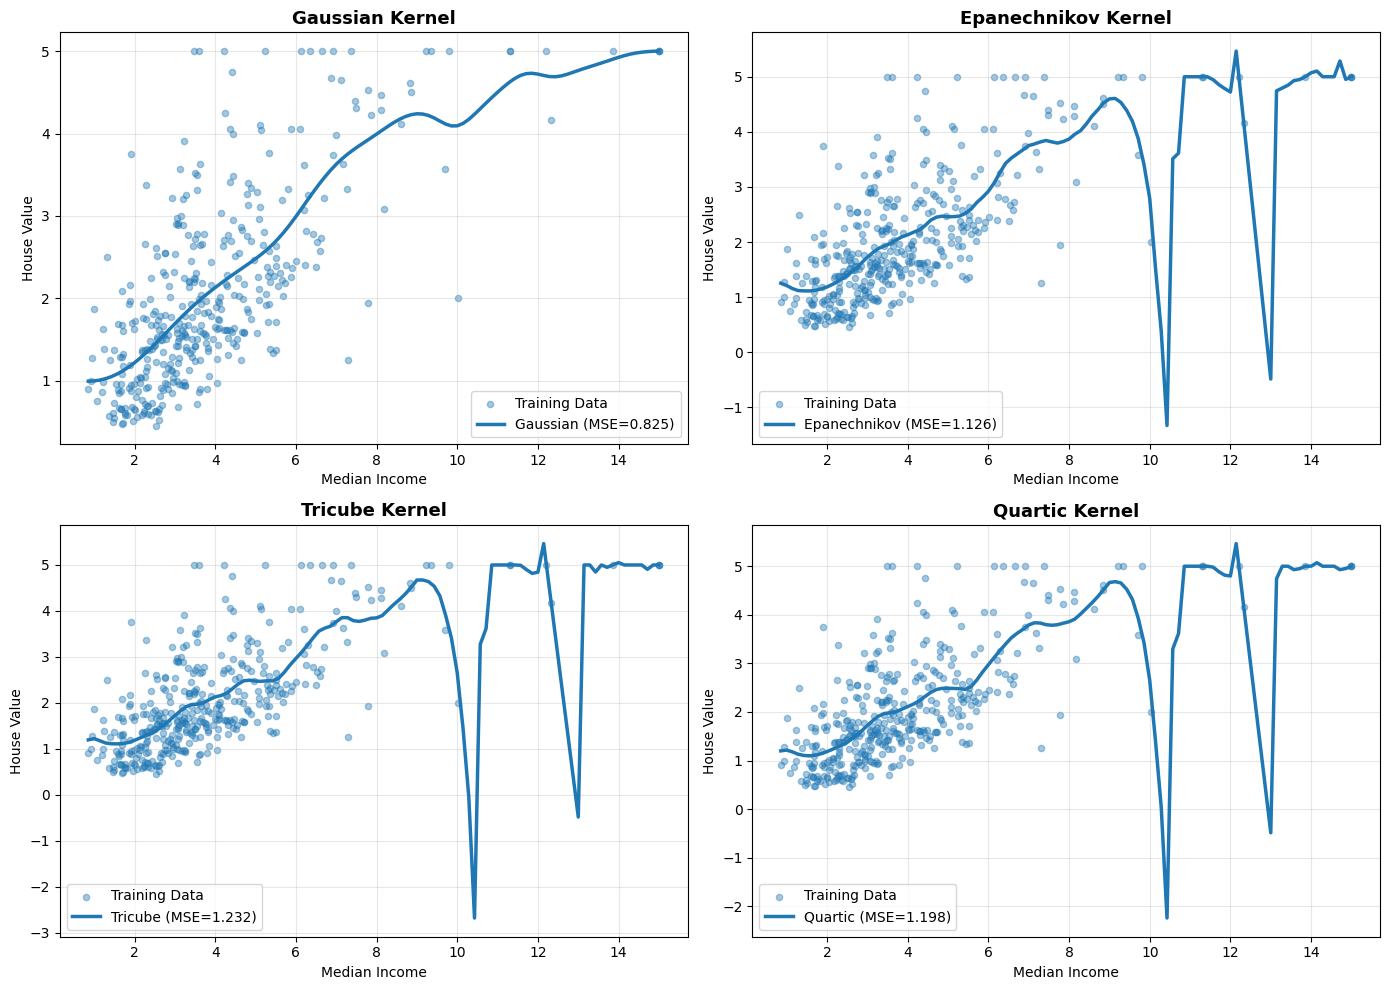


📊 KERNEL COMPARISON RESULTS (τ = 0.8)
Kernel          MSE          R²        
---------------------------------------------
Gaussian        0.8250       0.4339    
Epanechnikov    1.1264       0.2271    
Tricube         1.2317       0.1549    
Quartic         1.1980       0.1780    

🏆 Best kernel: Gaussian


In [5]:
# ═══════════════════════════════════════════════════════════════
# 📊 KERNEL COMPARISON ON CALIFORNIA HOUSING
# ═══════════════════════════════════════════════════════════════

# Load and prepare data
california = fetch_california_housing()
X_full = california.data[:, 0]  # Median Income
y_full = california.target

# Sample for speed
np.random.seed(42)
idx = np.random.choice(len(X_full), 500, replace=False)
X_data = X_full[idx]
y_data = y_full[idx]

# Train-test split
split = int(0.8 * len(X_data))
X_train, X_test = X_data[:split], X_data[split:]
y_train, y_test = y_data[:split], y_data[split:]

# Test all kernels
tau = 0.8
kernels = ['gaussian', 'epanechnikov', 'tricube', 'quartic']
X_plot = np.linspace(X_train.min(), X_train.max(), 100)

fig, axes = plt.subplots(2, 2, figsize=(14, 10))
axes = axes.ravel()

results = {}
for ax, kernel in zip(axes, kernels):
    model = AdvancedLWLR(tau=tau, kernel=kernel)
    model.fit(X_train.reshape(-1, 1), y_train)
    
    y_plot = model.predict(X_plot.reshape(-1, 1))
    y_pred = model.predict(X_test.reshape(-1, 1))
    
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    results[kernel] = {'MSE': mse, 'R²': r2}
    
    ax.scatter(X_train, y_train, alpha=0.4, s=20, label='Training Data')
    ax.plot(X_plot, y_plot, linewidth=2.5, label=f'{kernel.capitalize()} (MSE={mse:.3f})')
    ax.set_title(f'{kernel.capitalize()} Kernel', fontsize=13, fontweight='bold')
    ax.set_xlabel('Median Income')
    ax.set_ylabel('House Value')
    ax.legend()
    ax.grid(alpha=0.3)

plt.tight_layout()
plt.show()

# Summary table
print("\n📊 KERNEL COMPARISON RESULTS (τ = 0.8)")
print("=" * 45)
print(f"{'Kernel':<15} {'MSE':<12} {'R²':<10}")
print("-" * 45)
for kernel, metrics in results.items():
    print(f"{kernel.capitalize():<15} {metrics['MSE']:<12.4f} {metrics['R²']:<10.4f}")
print("=" * 45)

best_kernel = min(results, key=lambda x: results[x]['MSE'])
print(f"\n🏆 Best kernel: {best_kernel.capitalize()}")

## 5. 🎯 Automatic Tau Selection via Cross-Validation

Choosing tau manually is tedious. Let's automate it using cross-validation!

**The idea:** Try many tau values, evaluate each using K-fold CV, pick the one with lowest validation error.

🔍 Searching for optimal tau with 5-fold CV...


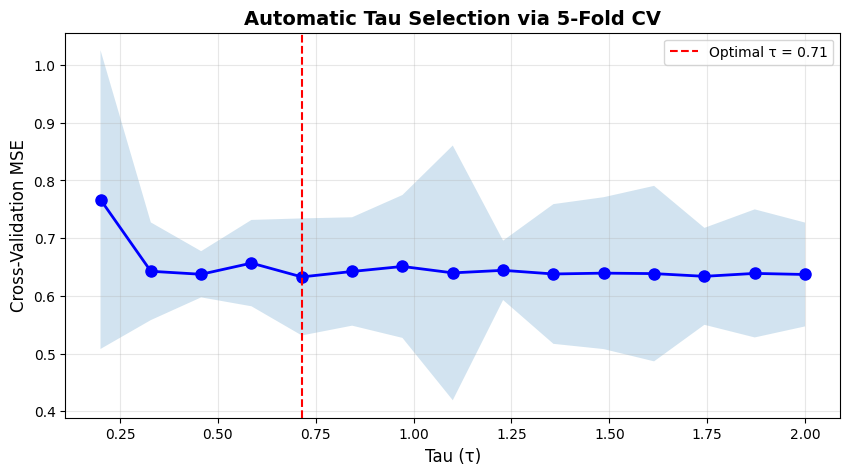


🏆 Optimal tau: 0.71
   CV MSE: 0.6328 ± 0.1014


In [6]:
# ═══════════════════════════════════════════════════════════════
# 🎯 AUTOMATIC TAU SELECTION WITH CROSS-VALIDATION
# ═══════════════════════════════════════════════════════════════

def cross_validate_lwlr(X, y, tau, kernel='gaussian', k_folds=5):
    """Perform k-fold cross-validation for LWLR"""
    n = len(X)
    fold_size = n // k_folds
    indices = np.arange(n)
    np.random.shuffle(indices)
    
    mse_scores = []
    
    for i in range(k_folds):
        # Split data
        val_idx = indices[i*fold_size:(i+1)*fold_size]
        train_idx = np.concatenate([indices[:i*fold_size], indices[(i+1)*fold_size:]])
        
        X_tr, X_val = X[train_idx], X[val_idx]
        y_tr, y_val = y[train_idx], y[val_idx]
        
        # Train and evaluate
        model = AdvancedLWLR(tau=tau, kernel=kernel)
        model.fit(X_tr.reshape(-1, 1), y_tr)
        y_pred = model.predict(X_val.reshape(-1, 1))
        
        mse_scores.append(mean_squared_error(y_val, y_pred))
    
    return np.mean(mse_scores), np.std(mse_scores)

def find_optimal_tau(X, y, tau_range, kernel='gaussian', k_folds=5):
    """Find optimal tau using cross-validation"""
    results = []
    
    print(f"🔍 Searching for optimal tau with {k_folds}-fold CV...")
    for tau in tau_range:
        mean_mse, std_mse = cross_validate_lwlr(X, y, tau, kernel, k_folds)
        results.append({'tau': tau, 'mean_mse': mean_mse, 'std_mse': std_mse})
    
    best = min(results, key=lambda x: x['mean_mse'])
    return results, best

# Search for optimal tau
tau_range = np.linspace(0.2, 2.0, 15)
cv_results, best_result = find_optimal_tau(X_train, y_train, tau_range)

# Visualize results
taus = [r['tau'] for r in cv_results]
mses = [r['mean_mse'] for r in cv_results]
stds = [r['std_mse'] for r in cv_results]

plt.figure(figsize=(10, 5))
plt.plot(taus, mses, 'bo-', linewidth=2, markersize=8)
plt.fill_between(taus, 
                 np.array(mses) - np.array(stds), 
                 np.array(mses) + np.array(stds), 
                 alpha=0.2)
plt.axvline(best_result['tau'], color='red', linestyle='--', 
            label=f"Optimal τ = {best_result['tau']:.2f}")
plt.xlabel('Tau (τ)', fontsize=12)
plt.ylabel('Cross-Validation MSE', fontsize=12)
plt.title('Automatic Tau Selection via 5-Fold CV', fontsize=14, fontweight='bold')
plt.legend()
plt.grid(alpha=0.3)
plt.show()

print(f"\n🏆 Optimal tau: {best_result['tau']:.2f}")
print(f"   CV MSE: {best_result['mean_mse']:.4f} ± {best_result['std_mse']:.4f}")

## 6. 🌐 Multi-Dimensional LWLR

Real-world data usually has **multiple features**. Let's extend LWLR to handle multi-dimensional inputs.

**Challenge:** In high dimensions, distances behave differently (curse of dimensionality). We need to:
1. **Scale features** before computing distances
2. Potentially use **different tau per dimension** (anisotropic bandwidth)

📊 Dataset: 640 training, 160 test samples
📐 Features: ['MedInc', 'HouseAge', 'AveRooms', 'AveBedrms']


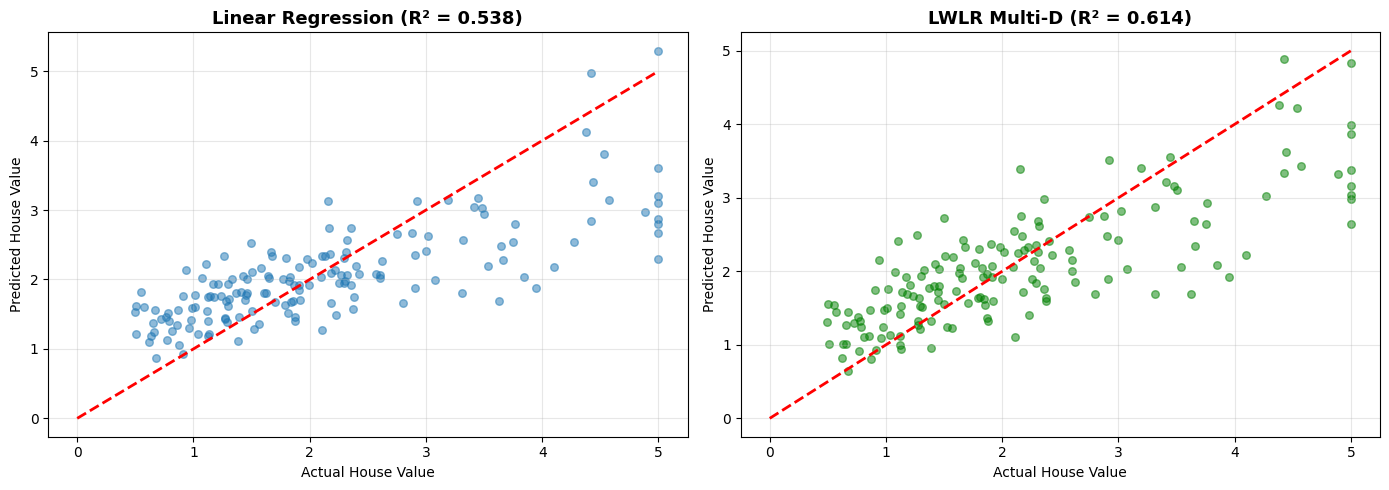


📊 MULTI-DIMENSIONAL COMPARISON:
Model                MSE          R²        
---------------------------------------------
Linear Regression    0.6770       0.5384    
LWLR (4 features)    0.5655       0.6145    


In [7]:
# ═══════════════════════════════════════════════════════════════
# 🌐 MULTI-DIMENSIONAL LWLR
# ═══════════════════════════════════════════════════════════════

# Load multi-dimensional California Housing data
california = fetch_california_housing()

# Use multiple features: MedInc, HouseAge, AveRooms, AveBedrms
feature_names = ['MedInc', 'HouseAge', 'AveRooms', 'AveBedrms']
feature_indices = [0, 1, 2, 3]

X_multi = california.data[:, feature_indices]
y_multi = california.target

# Sample for speed
np.random.seed(42)
idx = np.random.choice(len(X_multi), 800, replace=False)
X_multi = X_multi[idx]
y_multi = y_multi[idx]

# CRITICAL: Scale features for distance-based methods!
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_multi)

# Train-test split
split = int(0.8 * len(X_scaled))
X_train_m, X_test_m = X_scaled[:split], X_scaled[split:]
y_train_m, y_test_m = y_multi[:split], y_multi[split:]

print(f"📊 Dataset: {X_train_m.shape[0]} training, {X_test_m.shape[0]} test samples")
print(f"📐 Features: {feature_names}")

# Train multi-dimensional LWLR
tau_multi = 1.5  # Larger tau for higher dimensions
model_multi = AdvancedLWLR(tau=tau_multi, kernel='gaussian')
model_multi.fit(X_train_m, y_train_m)

# Evaluate
y_pred_multi = model_multi.predict(X_test_m)
mse_multi = mean_squared_error(y_test_m, y_pred_multi)
r2_multi = r2_score(y_test_m, y_pred_multi)

# Compare with Standard LR
lr = LinearRegression()
lr.fit(X_train_m, y_train_m)
y_pred_lr = lr.predict(X_test_m)
mse_lr = mean_squared_error(y_test_m, y_pred_lr)
r2_lr = r2_score(y_test_m, y_pred_lr)

# Visualize predictions
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

axes[0].scatter(y_test_m, y_pred_lr, alpha=0.5, s=30)
axes[0].plot([0, 5], [0, 5], 'r--', linewidth=2)
axes[0].set_xlabel('Actual House Value')
axes[0].set_ylabel('Predicted House Value')
axes[0].set_title(f'Linear Regression (R² = {r2_lr:.3f})', fontsize=13, fontweight='bold')
axes[0].grid(alpha=0.3)

axes[1].scatter(y_test_m, y_pred_multi, alpha=0.5, s=30, color='green')
axes[1].plot([0, 5], [0, 5], 'r--', linewidth=2)
axes[1].set_xlabel('Actual House Value')
axes[1].set_ylabel('Predicted House Value')
axes[1].set_title(f'LWLR Multi-D (R² = {r2_multi:.3f})', fontsize=13, fontweight='bold')
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.show()

print("\n📊 MULTI-DIMENSIONAL COMPARISON:")
print("=" * 45)
print(f"{'Model':<20} {'MSE':<12} {'R²':<10}")
print("-" * 45)
print(f"{'Linear Regression':<20} {mse_lr:<12.4f} {r2_lr:<10.4f}")
print(f"{'LWLR (4 features)':<20} {mse_multi:<12.4f} {r2_multi:<10.4f}")
print("=" * 45)

## 7. 🔄 LWLR vs Related Methods

Let's compare LWLR with other local/kernel-based methods:

| Method | Type | Stores Data | Learns Local Model | Complexity |
|--------|------|-------------|-------------------|------------|
| **LWLR** | Local parametric | Yes | Yes (weighted LR) | O(n³) per query |
| **KNN Regression** | Non-parametric | Yes | No (averaging) | O(n) per query |
| **Kernel Ridge** | Global kernel | Yes | No (global fit) | O(n³) training |

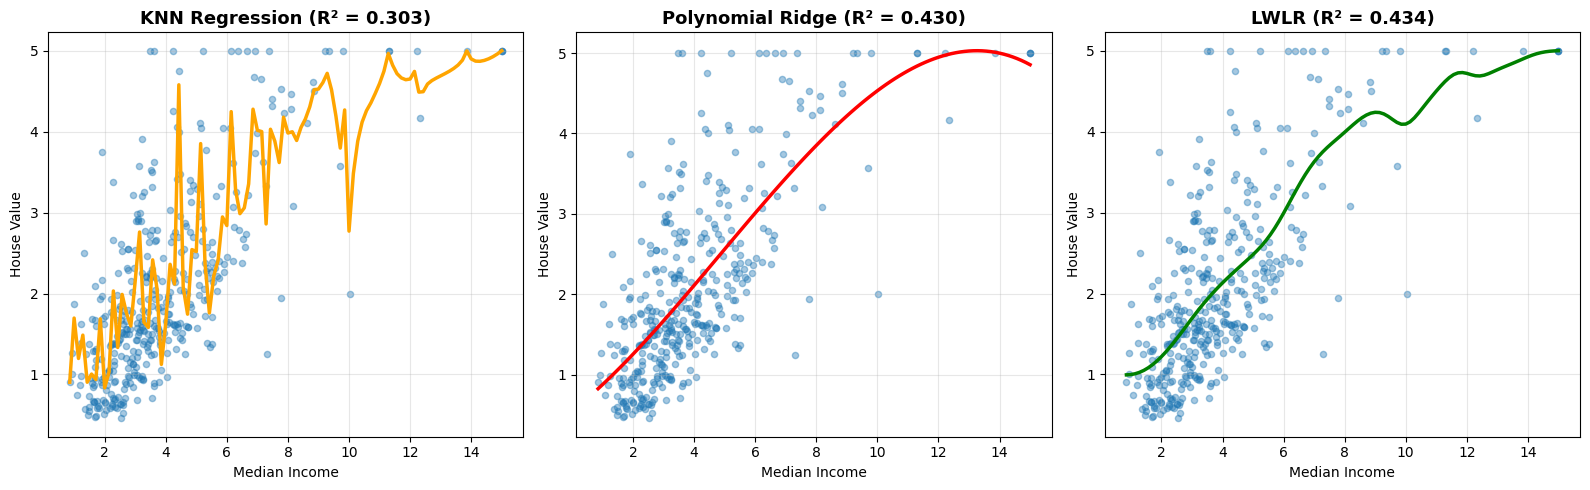


📊 METHOD COMPARISON:
Method               MSE          R²         Prediction Speed
-------------------------------------------------------
KNN Regression       1.0154       0.3033     Fast
Polynomial Ridge     0.8303       0.4303     Fast
LWLR (Gaussian)      0.8250       0.4339     Slower

🎯 KEY INSIGHTS:
   • LWLR fits local linear models → smoother curves
   • KNN simply averages → can be choppy
   • Ridge is global → can't capture local variations
   • LWLR is slowest but most flexible for non-linear local patterns


In [8]:
# ═══════════════════════════════════════════════════════════════
# 🔄 COMPARE LWLR WITH KNN AND KERNEL RIDGE REGRESSION
# ═══════════════════════════════════════════════════════════════

# Use same data from earlier kernel comparison
np.random.seed(42)

# KNN Regression
knn = KNeighborsRegressor(n_neighbors=10, weights='distance')
knn.fit(X_train.reshape(-1, 1), y_train)
y_pred_knn = knn.predict(X_test.reshape(-1, 1))
mse_knn = mean_squared_error(y_test, y_pred_knn)
r2_knn = r2_score(y_test, y_pred_knn)

# Kernel Ridge Regression (approximated with standard Ridge + polynomial features)
from sklearn.preprocessing import PolynomialFeatures
poly = PolynomialFeatures(degree=3)
X_train_poly = poly.fit_transform(X_train.reshape(-1, 1))
X_test_poly = poly.transform(X_test.reshape(-1, 1))

ridge = Ridge(alpha=1.0)
ridge.fit(X_train_poly, y_train)
y_pred_ridge = ridge.predict(X_test_poly)
mse_ridge = mean_squared_error(y_test, y_pred_ridge)
r2_ridge = r2_score(y_test, y_pred_ridge)

# LWLR (best kernel from earlier)
model_best = AdvancedLWLR(tau=0.8, kernel='gaussian')
model_best.fit(X_train.reshape(-1, 1), y_train)
y_pred_lwlr = model_best.predict(X_test.reshape(-1, 1))
mse_lwlr = mean_squared_error(y_test, y_pred_lwlr)
r2_lwlr = r2_score(y_test, y_pred_lwlr)

# Visualization
X_plot = np.linspace(X_train.min(), X_train.max(), 100)

fig, axes = plt.subplots(1, 3, figsize=(16, 5))

# KNN
knn_plot = knn.predict(X_plot.reshape(-1, 1))
axes[0].scatter(X_train, y_train, alpha=0.4, s=20)
axes[0].plot(X_plot, knn_plot, 'orange', linewidth=2.5)
axes[0].set_title(f'KNN Regression (R² = {r2_knn:.3f})', fontsize=13, fontweight='bold')
axes[0].set_xlabel('Median Income')
axes[0].set_ylabel('House Value')
axes[0].grid(alpha=0.3)

# Ridge
ridge_plot = ridge.predict(poly.transform(X_plot.reshape(-1, 1)))
axes[1].scatter(X_train, y_train, alpha=0.4, s=20)
axes[1].plot(X_plot, ridge_plot, 'red', linewidth=2.5)
axes[1].set_title(f'Polynomial Ridge (R² = {r2_ridge:.3f})', fontsize=13, fontweight='bold')
axes[1].set_xlabel('Median Income')
axes[1].set_ylabel('House Value')
axes[1].grid(alpha=0.3)

# LWLR
lwlr_plot = model_best.predict(X_plot.reshape(-1, 1))
axes[2].scatter(X_train, y_train, alpha=0.4, s=20)
axes[2].plot(X_plot, lwlr_plot, 'green', linewidth=2.5)
axes[2].set_title(f'LWLR (R² = {r2_lwlr:.3f})', fontsize=13, fontweight='bold')
axes[2].set_xlabel('Median Income')
axes[2].set_ylabel('House Value')
axes[2].grid(alpha=0.3)

plt.tight_layout()
plt.show()

# Comparison Table
print("\n📊 METHOD COMPARISON:")
print("=" * 55)
print(f"{'Method':<20} {'MSE':<12} {'R²':<10} {'Prediction Speed'}")
print("-" * 55)
print(f"{'KNN Regression':<20} {mse_knn:<12.4f} {r2_knn:<10.4f} Fast")
print(f"{'Polynomial Ridge':<20} {mse_ridge:<12.4f} {r2_ridge:<10.4f} Fast")
print(f"{'LWLR (Gaussian)':<20} {mse_lwlr:<12.4f} {r2_lwlr:<10.4f} Slower")
print("=" * 55)

print("\n🎯 KEY INSIGHTS:")
print("   • LWLR fits local linear models → smoother curves")
print("   • KNN simply averages → can be choppy")
print("   • Ridge is global → can't capture local variations")
print("   • LWLR is slowest but most flexible for non-linear local patterns")

## 8. 📝 Summary & Key Takeaways

### What We Learned:

| Topic | Key Insight |
|-------|-------------|
| **Kernel Functions** | Different kernels (Gaussian, Epanechnikov, Tricube, Quartic) have different smoothness and support properties |
| **Compact Support** | Epanechnikov/Tricube/Quartic kernels are faster (only consider nearby points) |
| **Tau Selection** | Cross-validation automates bandwidth selection - no more guessing! |
| **Multi-Dimensional** | Feature scaling is CRITICAL for distance-based methods |
| **vs. KNN** | LWLR fits local models; KNN just averages - LWLR is smoother |
| **vs. Kernel Ridge** | Kernel Ridge is global; LWLR captures local variations |

### When to Use LWLR:

✅ **Use LWLR when:**
- Data has non-linear relationships
- Different regions have different slopes
- You need smooth local predictions
- Interpretability matters (local coefficients)

❌ **Avoid LWLR when:**
- Dataset is very large (slow predictions)
- Real-time predictions required
- High-dimensional data (curse of dimensionality)
- Extrapolation is needed (LWLR is terrible at extrapolation)

### Practical Tips:

1. **Always scale features** before using LWLR on multi-dimensional data
2. **Use cross-validation** to select tau - don't guess!
3. **Consider compact kernels** (Epanechnikov) for speed on large datasets
4. **Increase tau in higher dimensions** - distances get larger
5. **LWLR doesn't extrapolate** - only use within training data range

In [10]:
# ═══════════════════════════════════════════════════════════════
# 🎓 FINAL VISUALIZATION: SUMMARY OF ALL TECHNIQUES
# ═══════════════════════════════════════════════════════════════

print("=" * 60)
print("🎓 MODULE 05 ADVANCED LWLR - COMPLETE!")
print("=" * 60)
print()
print("📚 Topics Covered:")
print("   1. Setup & Imports")
print("   2. Different Kernel Functions (4 types)")
print("   3. AdvancedLWLR Class Implementation")
print("   4. Kernel Comparison on Real Data")
print("   5. Automatic Tau Selection via Cross-Validation")
print("   6. Multi-Dimensional LWLR")
print("   7. Comparison with KNN and Kernel Ridge")
print("   8. Summary & Key Takeaways")
print()
print("🔑 Key Skills Acquired:")
print("   ✓ Implement multiple kernel functions")
print("   ✓ Choose appropriate kernel for your data")
print("   ✓ Automatically select optimal bandwidth (tau)")
print("   ✓ Apply LWLR to multi-dimensional data")
print("   ✓ Compare LWLR with alternative methods")
print()
print("🚀 Next Steps:")
print("   → Try the Real Case Study: Temperature Prediction")
print("   → Experiment with your own datasets")
print("   → Compare computational costs on larger data")
print("=" * 60)

🎓 MODULE 05 ADVANCED LWLR - COMPLETE!

📚 Topics Covered:
   1. Setup & Imports
   2. Different Kernel Functions (4 types)
   3. AdvancedLWLR Class Implementation
   4. Kernel Comparison on Real Data
   5. Automatic Tau Selection via Cross-Validation
   6. Multi-Dimensional LWLR
   7. Comparison with KNN and Kernel Ridge
   8. Summary & Key Takeaways

🔑 Key Skills Acquired:
   ✓ Implement multiple kernel functions
   ✓ Choose appropriate kernel for your data
   ✓ Automatically select optimal bandwidth (tau)
   ✓ Apply LWLR to multi-dimensional data
   ✓ Compare LWLR with alternative methods

🚀 Next Steps:
   → Try the Real Case Study: Temperature Prediction
   → Experiment with your own datasets
   → Compare computational costs on larger data
